#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Análisis de Grandes Volúmenes de Datos**
###Tecnológico de Monterrey
###Prof. Iván Olmos

## **Actividad Semana 03**

###**Proyecto: Base de Datos de Big Data**

##### Nombres y matrículas de los integrantes del equipo:
*   Victoria Melgarejo Cabrera - A01795030
*   Héctor Alejandro Alvarez Rosas        - A01796262
*   Andrea Xcaret Gomez Alfaro        - A01796384
*   Mario Guillen De La Torre       - A01796701


---


#### **Descripción de la Actividad:**

Identificar una base de datos de big data para la aplicación de los conceptos aprendidos en el curso, iniciando con la manipulación básica de lectura y escritura de archivos con PySpark.



---

In [1]:
# Instalación de PySpark en Colab
!pip install pyspark

### **Importación de Librerías**

In [2]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, isnan, when, count, lit, percentile_approx, hour, dayofweek, unix_timestamp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [3]:
# Función auxiliar de visualización
from IPython.display import display, HTML

def prettyDisplay(df, limit=1000):
    """
    Convierte un PySpark DataFrame a Pandas y lo muestra como una tabla HTML con scroll horizontal.
    
    Args:
        df (pyspark.sql.DataFrame): El DataFrame de PySpark a mostrar.
        limit (int): Número máximo de filas a mostrar. Por defecto 1000.
    """
    pdf = df.limit(limit).toPandas()
    display(HTML(pdf.to_html(notebook=True)))

### **Creación de la Sesión Spark**

In [4]:
spark = SparkSession.builder \
    .appName("ChicagoTaxyTripsAnalysis") \
    .getOrCreate()

# Hide errors
spark.sparkContext.setLogLevel("ERROR")

25/05/03 14:18:17 WARN Utils: Your hostname, Hectors-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 192.168.0.113 instead (on interface en0)
25/05/03 14:18:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/03 14:18:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### **Carga del Dataset**

In [5]:
filename = "Taxi_Trips.csv"

dftaxytrips = spark.read.csv(filename, header=True, inferSchema=True)

In [6]:
print("Número de registros:", dftaxytrips.count())
print("Número de columnas:", len(dftaxytrips.columns))

[Stage 2:====================================>                    (16 + 8) / 25]

Número de registros: 7917844
Número de columnas: 23


### **Exploración de los Datos**

In [7]:
# Estructura del dataset
dftaxytrips.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [8]:
# Primeras filas
# dftaxytrips.show(5)
prettyDisplay(dftaxytrips, 5)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,01/19/2024 05:00:00 PM,01/19/2024 06:00:00 PM,4051,17.12,1.703198e+10,1.703132e+10,76,32.0,45.50,10.00,0.0,4.0,60.00,Credit Card,Flash Cab,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
1,000072ee076c9038868e239ca54185eb43959db0,e51e2c30caec952b40b8329a68b498e18ce8a1f40fa75c...,01/28/2024 02:30:00 PM,01/28/2024 03:00:00 PM,1749,12.70,NaN,NaN,6,NaN,33.75,0.00,0.0,0.0,33.75,Cash,Flash Cab,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),NaN,NaN,None
2,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,01/05/2024 09:00:00 AM,01/05/2024 09:00:00 AM,517,3.39,NaN,NaN,6,8.0,10.91,2.78,0.0,1.0,14.69,Mobile,Taxicab Insurance Agency Llc,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
3,00007572c5f92e2ff067e6f838a5ad74e83665d3,7d21c2ca227db8f27dda96612bfe5520ab408fa9a462c8...,01/22/2024 08:45:00 AM,01/22/2024 09:30:00 AM,2050,15.06,NaN,NaN,76,NaN,39.25,11.31,0.0,5.5,56.56,Credit Card,Globe Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,None
4,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,01/18/2024 07:15:00 PM,01/18/2024 07:30:00 PM,1004,1.18,1.703184e+10,1.703184e+10,32,32.0,15.94,3.72,0.0,0.0,19.66,Mobile,5 Star Taxi,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)


In [9]:
# dftaxytrips.summary().show()
prettyDisplay(dftaxytrips.summary())

,summary,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,count,7917844,7917844,7917844,7917778,7916303,7917775,3392900,3281682,7691067,7174891,7897269,7897269,7897269,7897269,7897269,7917844,7917844,7695376,7695376,7695376,7220191,7220191,7220191
1,mean,Infinity,None,None,None,1254.9250153764958,6.802327488467674,1.7031508395342648E10,1.703141394138261E10,36.09328575605959,26.293705646538744,22.89300292290886,2.9030046741474513,0.029434495646532992,2.1529685008830275,28.182303074643663,None,None,41.901399650735996,-87.7019076253514,None,41.8921376218955,-87.66080016228891,None
2,stddev,None,None,None,None,1648.0977197601726,7.957195844290252,374237.3662004645,342509.8545557547,26.291497670579886,20.81465342793271,33.2323786885119,4.284313925861233,5.0707919401752175,10.395597618506331,38.30632012119162,None,None,0.06525246745369662,0.11455514438305599,None,0.05843544231278496,0.07200598932628444,None
3,min,0000006aa752d456d05c6eeb43b057adb1ffa540,000daaa11a2d961100513e232a1ce05391c5d797d2dc56...,01/01/2024 01:00:00 AM,01/01/2024 01:00:00 AM,0,0.0,17031010100,17031010100,1,1,0.0,0.0,0.0,0.0,0.0,Cash,2733 - 74600 Benny Jona,41.650221676,-87.913624596,POINT (-87.5307124836 41.7030053028),41.650221676,-87.913624596,POINT (-87.5349029012 41.707311449)
4,25%,Infinity,None,None,None,480,1.03,17031081700,17031081500,8,8,8.5,0.0,0.0,0.0,10.25,None,None,41.878865584,-87.750934289,None,41.878865584,-87.66351755,None
5,50%,Infinity,None,None,None,943,3.34,17031320400,17031320100,32,28,16.0,0.57,0.0,0.0,19.22,None,None,41.89503345,-87.642648998,None,41.892042136,-87.633308037,None
6,75%,Infinity,None,None,None,1714,11.98,17031980000,17031839100,63,32,34.5,4.0,0.0,2.25,43.22,None,None,41.97907082,-87.625192142,None,41.922686284,-87.625192142,None
7,max,ffffffdda8f2f9f98cf474cce05b7e5e34dc25e4,ffda53354c610fd3af1aee46d723028a49014e35f7280c...,12/31/2024 12:45:00 PM,12/31/2024 12:45:00 PM,86396,3397.8,17031980100,17031980100,77,77,9999.75,400.0,5550.0,5559.5,9999.75,Unknown,Wolley Taxi,42.021223593,-87.530712484,POINT (-87.913624596 41.9802643146),42.021223593,-87.534902901,POINT (-87.913624596 41.9802643146)


In [10]:
# Estadísticas generales
# dftaxytrips.describe().show()
prettyDisplay(dftaxytrips.describe())

,summary,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,count,7917844,7917844,7917844,7917778,7916303,7917775,3392900,3281682,7691067,7174891,7897269,7897269,7897269,7897269,7897269,7917844,7917844,7695376,7695376,7695376,7220191,7220191,7220191
1,mean,Infinity,None,None,None,1254.9250153764958,6.802327488467674,1.7031508395342648E10,1.703141394138261E10,36.09328575605959,26.293705646538744,22.89300292290886,2.9030046741474513,0.029434495646532992,2.1529685008830275,28.182303074643663,None,None,41.901399650735996,-87.7019076253514,None,41.8921376218955,-87.66080016228891,None
2,stddev,None,None,None,None,1648.0977197601726,7.957195844290252,374237.3662004645,342509.8545557547,26.291497670579886,20.81465342793271,33.2323786885119,4.284313925861233,5.0707919401752175,10.395597618506331,38.30632012119162,None,None,0.06525246745369662,0.11455514438305599,None,0.05843544231278496,0.07200598932628444,None
3,min,0000006aa752d456d05c6eeb43b057adb1ffa540,000daaa11a2d961100513e232a1ce05391c5d797d2dc56...,01/01/2024 01:00:00 AM,01/01/2024 01:00:00 AM,0,0.0,17031010100,17031010100,1,1,0.0,0.0,0.0,0.0,0.0,Cash,2733 - 74600 Benny Jona,41.650221676,-87.913624596,POINT (-87.5307124836 41.7030053028),41.650221676,-87.913624596,POINT (-87.5349029012 41.707311449)
4,max,ffffffdda8f2f9f98cf474cce05b7e5e34dc25e4,ffda53354c610fd3af1aee46d723028a49014e35f7280c...,12/31/2024 12:45:00 PM,12/31/2024 12:45:00 PM,86396,3397.8,17031980100,17031980100,77,77,9999.75,400.0,5550.0,5559.5,9999.75,Unknown,Wolley Taxi,42.021223593,-87.530712484,POINT (-87.913624596 41.9802643146),42.021223593,-87.534902901,POINT (-87.913624596 41.9802643146)


In [11]:
# Análisis de valores únicos

unique_values = []

# Recorremos cada columna y guardamos info
for col_name in dftaxytrips.columns:
    distinct_count = dftaxytrips.select(col_name).distinct().count()
    data_type = [f.dataType for f in dftaxytrips.schema.fields if f.name == col_name][0]
    
    unique_values.append(Row(Columna=col_name, TipoDato=str(data_type), ValoresUnicos=distinct_count))

# Creamos un nuevo DataFrame con los resultados
unique_df = spark.createDataFrame(unique_values)

# Mostramos la tabla ordenada por número de valores únicos
prettyDisplay(unique_df.orderBy("ValoresUnicos", ascending=False))

,Columna,TipoDato,ValoresUnicos
0,Trip ID,StringType(),7917844
1,Trip End Timestamp,StringType(),43785
2,Trip Start Timestamp,StringType(),43769
3,Trip Seconds,IntegerType(),17001
4,Trip Total,DoubleType(),15840
5,Fare,DoubleType(),10170
6,Trip Miles,DoubleType(),7720
7,Tips,DoubleType(),3733
8,Extras,DoubleType(),3513
9,Taxi ID,StringType(),3409


In [12]:
# Lista para guardar los resultados
missing_data = []

# Recorremos cada columna
for c in dftaxytrips.columns:
    null_count = dftaxytrips.filter(col(c).isNull() | isnan(c)).count()
    null_percent = (null_count / dftaxytrips.count()) * 100
    missing_data.append(Row(Columna=c, Faltantes=null_count, Porcentaje=round(null_percent, 2)))

# Creamos un nuevo DataFrame
missing_df = spark.createDataFrame(missing_data)

# Ordenamos de mayor a menor según porcentaje
prettyDisplay(missing_df.orderBy("Porcentaje", ascending=False))

,Columna,Faltantes,Porcentaje
0,Dropoff Census Tract,4636162,58.55
1,Pickup Census Tract,4524944,57.15
2,Dropoff Community Area,742953,9.38
3,Dropoff Centroid Latitude,697653,8.81
4,Dropoff Centroid Longitude,697653,8.81
5,Dropoff Centroid Location,697653,8.81
6,Pickup Community Area,226777,2.86
7,Pickup Centroid Longitude,222468,2.81
8,Pickup Centroid Latitude,222468,2.81
9,Pickup Centroid Location,222468,2.81


Vemos que las columnas Dropoff Census Tract y Pickup Census Tract las podemos eliminar, ya que contienen una gran cantidad de valores faltantas y no son variables que nos interesen tener en el análisis. Es decir, no serán consideradas como variables de caracterización.

In [13]:
categoric_cols = [
    "Trip ID",
    "Taxi ID",
    "Trip Start Timestamp",
    "Trip End Timestamp",
    "Payment Type",
    "Company",
    "Pickup Centroid Location",
    "Dropoff Centroid  Location"
]
numeric_cols = [
    "Trip Seconds",
    "Trip Miles",
    "Pickup Census Tract",
    "Dropoff Census Tract",
    "Pickup Community Area",
    "Dropoff Community Area",
    "Fare",
    "Tips",
    "Tolls",
    "Extras",
    "Trip Total",
    "Pickup Centroid Latitude",
    "Pickup Centroid Longitude",
    "Dropoff Centroid Latitude",
    "Dropoff Centroid Longitude"
]

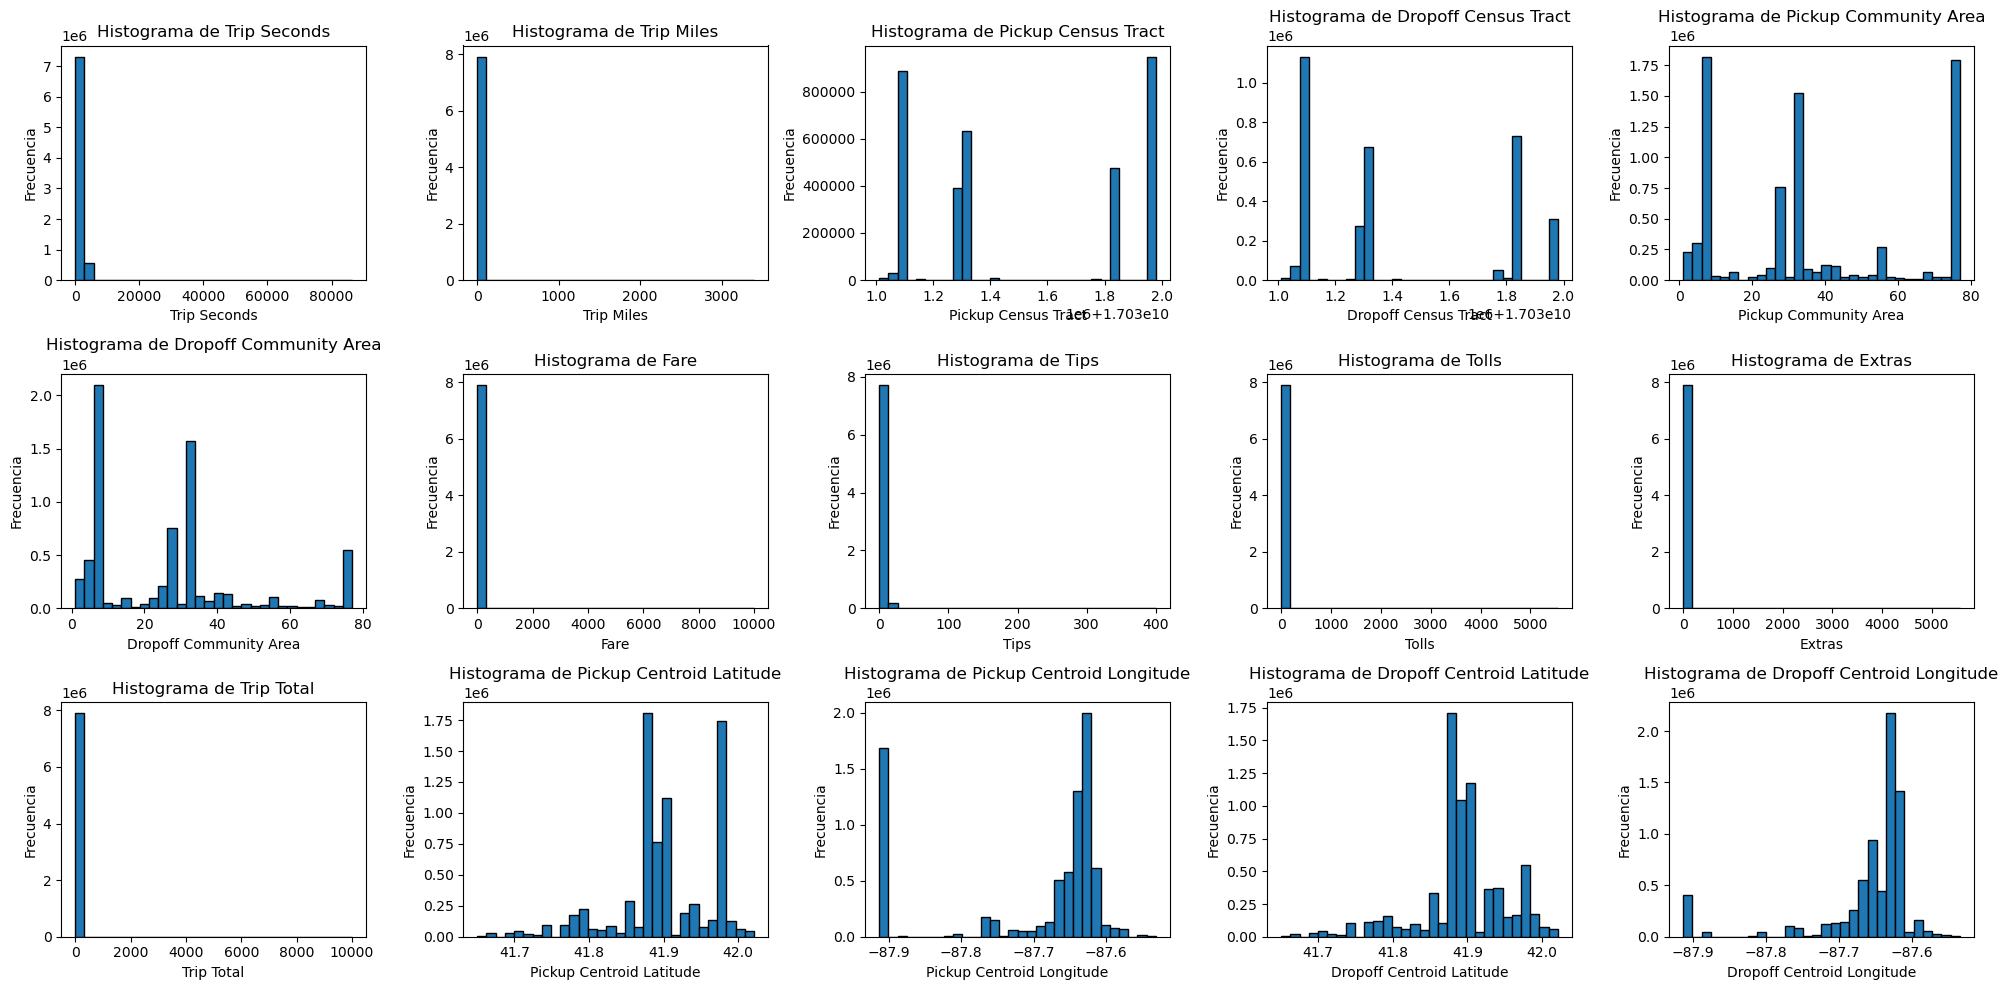

In [14]:
# Graficar histogramas 
plt.figure(figsize=(20, 10))
for i, column in enumerate(numeric_cols, 1):
    # Obtener los datos de la columna después de eliminar los valores atípicos
    data = dftaxytrips.select(column).dropna().rdd.flatMap(lambda x: x).collect()

    # Graficar el histograma
    plt.subplot(3, 5, i)
    plt.hist(data, bins=30, edgecolor='black')
    plt.title(f"Histograma de {column}")
    plt.xlabel(column)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

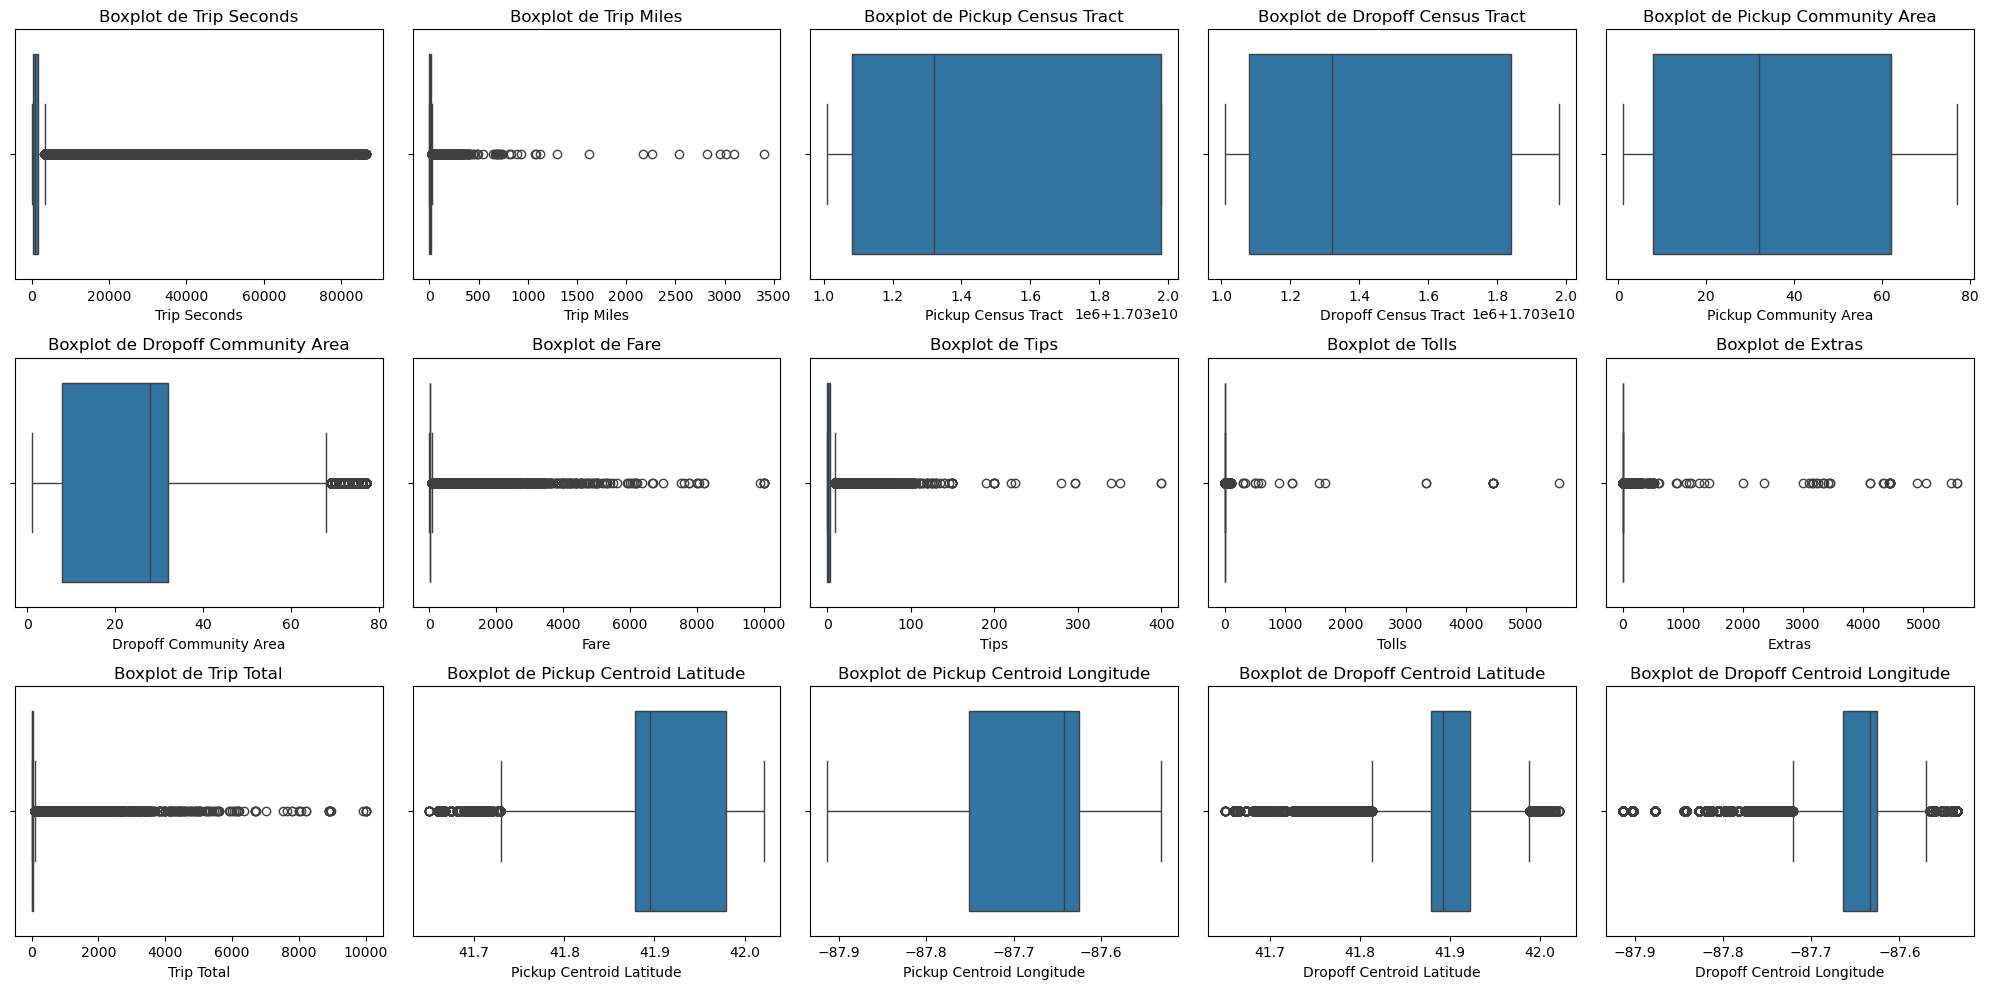

In [15]:
# Graficar los boxplots
plt.figure(figsize=(20, 10))
for i, column in enumerate(numeric_cols, 1):
    # Obtener los datos de la columna
    data = dftaxytrips.select(column).dropna().rdd.flatMap(lambda x: x).collect()

    # Graficar el boxplot
    plt.subplot(3, 5, i)
    sns.boxplot(x=data)
    plt.title(f"Boxplot de {column}")
    plt.xlabel(column)

plt.tight_layout()
plt.show()

/var/folders/_f/_6tlx7c13c37kj_7y13098dr0000gn/T/ipykernel_27561/3654668573.py:26: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


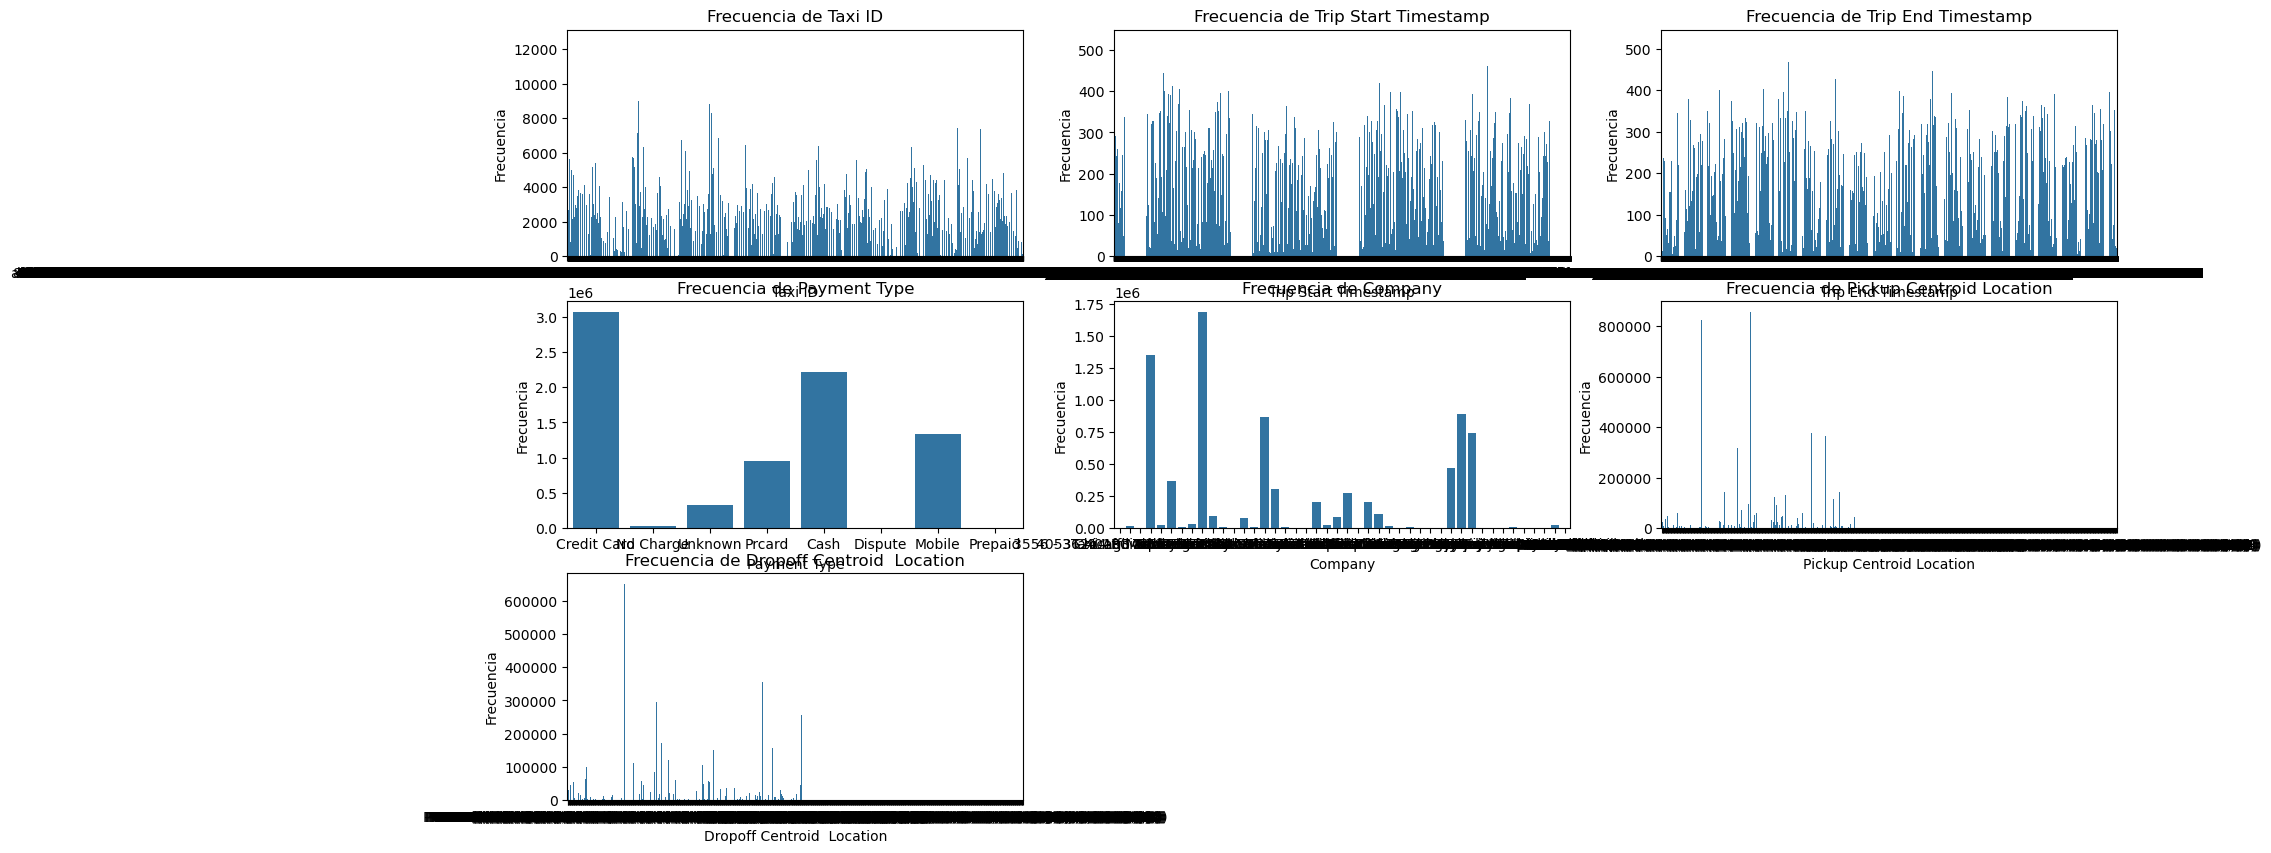

In [16]:
categoric_cols_to_plot = [
    # "Trip ID", // Id único por registro, no es necesario gráficar.
    "Taxi ID",
    "Trip Start Timestamp",
    "Trip End Timestamp",
    "Payment Type",
    "Company",
    "Pickup Centroid Location",
    "Dropoff Centroid  Location"
]
# Visualización de los valores de las columnas categóricas
plt.figure(figsize=(20, 10))

for i, column in enumerate(categoric_cols_to_plot, 1):
    plt.subplot(3, 3, i)
    # Contar las frecuencias de cada categoría
    df_filtered = dftaxytrips.select(column).dropna()  # Eliminar valores nulos
    value_counts = df_filtered.groupBy(column).count().toPandas()

    # Gráfico de barras para cada columna
    sns.barplot(x=column, y="count", data=value_counts)
    plt.title(f"Frecuencia de {column}")
    plt.xlabel(column)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()